# MLIP with ASE Tutorial

This notebook demonstrates how to integrate a machine-learned interatomic potential (MLIP) with ASE for:
- Geometry optimizations
- Molecular dynamics (MD) simulations
- Nudged Elastic Band (NEB) calculations

Ensure you have an MLIP potential (loaded in you envronment) and example structures (`initial.xyz`, `final.xyz`) in your working directory.

## 1. Setup & Imports

In [36]:
import numpy as np
import matplotlib.pyplot as plt

from ase import Atoms, units
from ase.io import read, write
from ase.visualize import view
from ase.visualize.plot import plot_atoms

## 2. Geometry Optimization with EMT (Baseline)
We start by using the classical EMT potential for initial geometry optimization.
This provides a quick baseline before switching to more accurate MLIPs.

      Step     Time          Energy          fmax
BFGS:    0 17:28:58        4.028091        8.048738
BFGS:    1 17:28:58        2.449931        3.186848
BFGS:    2 17:28:58        2.017079        1.749374
BFGS:    3 17:28:58        1.886456        0.998144
BFGS:    4 17:28:58        1.824383        1.013382
BFGS:    5 17:28:58        1.732153        1.237173
BFGS:    6 17:28:58        1.703410        0.277504


/var/folders/q1/vfk5rpd96tq0pnfk76v4kcyw0000gp/T/ipykernel_9480/1424830338.py:8: FutureWarning: Please use atoms.calc = calc
  atoms.set_calculator(EMT())


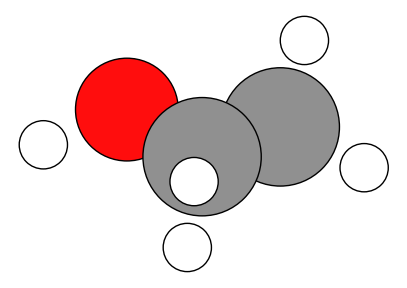

In [37]:
# Read a structure and assign EMT calculator
atoms = read('initial.xyz')

# Optimize with EMT
from ase.optimize import BFGS
from ase.calculators.emt import EMT

atoms.set_calculator(EMT())
opt = BFGS(atoms, trajectory='emt_opt.traj')
opt.run(fmax=0.5)

write('initial_optimized.xyz', atoms)
view(atoms)

fig, ax = plt.subplots(figsize=(5, 5))
plot_atoms(atoms, ax, rotation=('0x,0y,0z'))
ax.axis('off') 
plt.show()


## 3. Geometry Optimization with MLIP
Now we switch to a machine-learned interatomic potential (MLIP) for higher accuracy.

## 2. Load MLIP Model into ASE

In [38]:
# Load your trained MLIP potential
import torch
import torch._dynamo
torch._dynamo.config.suppress_errors = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#!pip install mace-torch
#pip install torch-dftd
from mace.calculators import mace_mp

mlip_calc = mace_mp(model="medium", dispersion=True, default_dtype="float64", device='cpu')

from ase.optimize import BFGS


Using Materials Project MACE for MACECalculator with /Users/vsathyas/.cache/mace/20231203mace128L1_epoch199model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
Using head Default out of ['Default']
Using TorchDFTD3Calculator for D3 dispersion corrections


## 3. Geometry Optimization Example

/var/folders/q1/vfk5rpd96tq0pnfk76v4kcyw0000gp/T/ipykernel_9480/1979346595.py:3: FutureWarning: Please use atoms.calc = calc
  atoms.set_calculator(mlip_calc)


      Step     Time          Energy          fmax
BFGS:    0 17:29:02      -47.269334        0.239886
Potential ENergy: -47.2693335450208


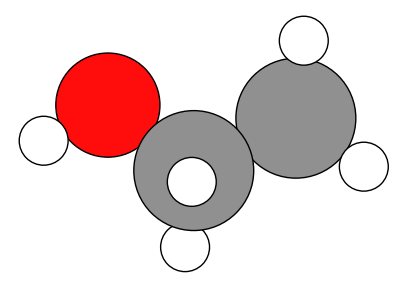

/var/folders/q1/vfk5rpd96tq0pnfk76v4kcyw0000gp/T/ipykernel_9480/1979346595.py:22: FutureWarning: Please use atoms.calc = calc
  atoms.set_calculator(mlip_calc)


      Step     Time          Energy          fmax
BFGS:    0 17:29:02      -45.764443        0.205591
Potential ENergy: -45.76444338531978


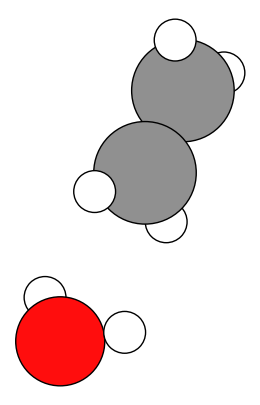

In [39]:

# Read a structure (e.g. POSCAR for a bulk cell or molecule)
atoms = read('initial.xyz')
atoms.set_calculator(mlip_calc)

# Run a BFGS optimization
opt = BFGS(atoms, trajectory='opt.traj')
opt.run(fmax=0.5)

# Save and view the optimized structure
write('initial_optimized.xyz', atoms)

# Calculate the potential energy of the optimized structure
print(f"Potential ENergy: {atoms.get_potential_energy()}")

# Visualize the optimized structure
fig, ax = plt.subplots(figsize=(5, 5))
plot_atoms(atoms, ax, rotation=('0x,0y,0z'))
ax.axis('off') 
plt.show()

atoms = read('final.xyz')
atoms.set_calculator(mlip_calc)

# Run a BFGS optimization
opt = BFGS(atoms, trajectory='opt.traj')
opt.run(fmax=0.5)

# Save and view the optimized structure
write('final_optimized.xyz', atoms)

# Calculate the potential energy of the optimized structure
print(f"Potential ENergy: {atoms.get_potential_energy()}")

# Visualize the optimized structure
fig, ax = plt.subplots(figsize=(5, 5))
plot_atoms(atoms, ax, rotation=('0x,0y,0z'))
ax.axis('off') 
plt.show()


## 4. Molecular Dynamics (MD) Simulation Example

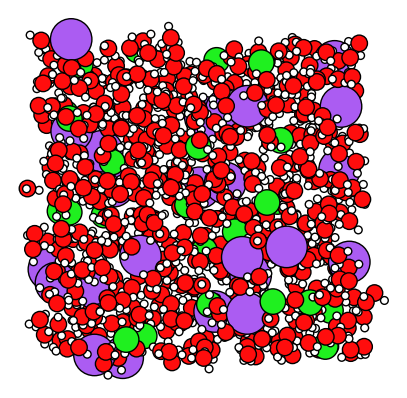

Using Materials Project MACE for MACECalculator with /Users/vsathyas/.cache/mace/20231203mace128L1_epoch199model
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Using head Default out of ['Default']
Default dtype float32 does not match model dtype float64, converting models to float32.


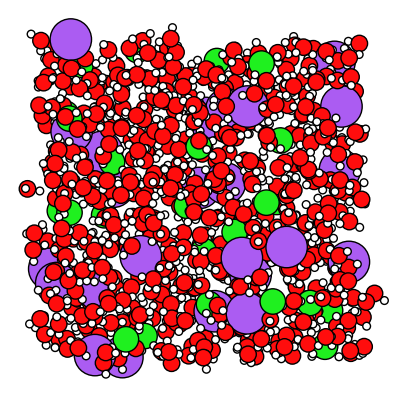

In [5]:
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.langevin import Langevin
from ase.md import MDLogger

atoms = read('NaClWater.xyz')
temp = 1000 #K

# Visualize the structure
fig, ax = plt.subplots(figsize=(5, 5))
plot_atoms(atoms, ax, rotation=('0x,0y,0z'))
ax.axis('off') 
plt.show()
view(atoms)

atoms.calc = mace_mp(model="medium", dispersion=True, default_dtype="float64", device='cpu')
MaxwellBoltzmannDistribution(atoms, temperature_K=temp)

dyn = Langevin(atoms, 0.5 * units.fs, temperature_K=temp, friction=0.01 / units.fs)
dyn.attach(lambda: write('md.xyz', atoms.copy(), append=True), interval=1)
dyn.attach(MDLogger(dyn, atoms, "md.log"), interval=1)
dyn.run(10)

# Visualize the structure
fig, ax = plt.subplots(figsize=(5, 5))
plot_atoms(atoms, ax, rotation=('0x,0y,0z'))
ax.axis('off') 
plt.show()


## 5. Nudged Elastic Band (NEB) Calculation Example

Using Materials Project MACE for MACECalculator with /Users/vsathyas/.cache/mace/20231203mace128L1_epoch199model
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Using head Default out of ['Default']
Default dtype float32 does not match model dtype float64, converting models to float32.
Using TorchDFTD3Calculator for D3 dispersion corrections
Using Materials Project MACE for MACECalculator with /Users/vsathyas/.cache/mace/20231203mace128L1_epoch199model
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Using head Default out of ['Default']
Default dtype float32 does not match model dtype float64, converting models to float32.
Using TorchDFTD3Calculator for D3 dispersion corrections
Using Materials Project MACE for MACECalculator with /Users/vsathyas/.cache/mace/20231203mace128L1_epoch199model
Using float32 for MACECalculator, which

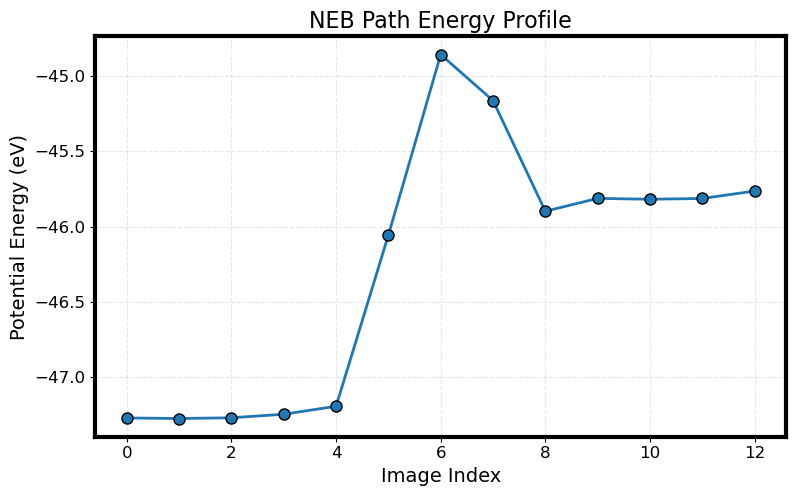

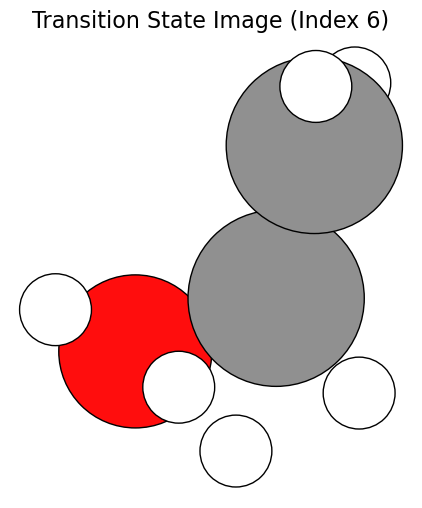

<Popen: returncode: None args: ['/opt/anaconda3/bin/python', '-m', 'ase', 'g...>

In [6]:
from ase.mep import NEB 

# Load initial and final states
initial = read('initial_optimized.xyz')
final = read('final_optimized.xyz')

# Create intermediate images
images = [initial]
n_images = 11
for i in range(n_images):
    img = initial.copy()
    images.append(img)
images.append(final)

# Assign calculator to each image
for img in images:
    img.calc = mace_mp(model="medium", dispersion=True, default_dtype="float64", device='cpu')  # Replace with your MLIP calculator

# Set up NEB
neb = NEB(images)
neb.interpolate()

# Optimize with FIRE
#optimizer = FIRE(neb)
optimizer = BFGS(neb)
optimizer.run(fmax=0.5)

# Save NEB images
for idx, img in enumerate(images):
    write(f'neb_image_{idx}.xyz', img)

# Extract energies and plot
energies = [img.get_potential_energy() for img in images]
plt.figure(figsize=(8, 5))

# Plot line with wider axis lines and larger markers
plt.plot(range(len(energies)), energies, 'o-', linewidth=2, markersize=8, color='tab:blue',markeredgecolor='black')

# Axis labels and title with larger font
plt.xlabel('Image Index', fontsize=14)
plt.ylabel('Potential Energy (eV)', fontsize=14)
plt.title('NEB Path Energy Profile', fontsize=16)

# Customize grid and spines
plt.grid(True, alpha=0.3, linestyle='--')  # lighter, dashed grid
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(3)  # set axis line width

# Improve ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

ts_index = np.argmax(energies)
ts_image = images[ts_index]

# Plot the TS image clearly
fig, ax = plt.subplots(figsize=(6, 6))
plot_atoms(ts_image, ax, rotation=('0x,0y,0z'))
ax.set_title(f'Transition State Image (Index {ts_index})', fontsize=16)
ax.axis('off')
plt.show()
view(ts_image)


## 6. Absorption Energy Calculation Example

Using Materials Project MACE for MACECalculator with /Users/vsathyas/.cache/mace/20231203mace128L1_epoch199model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
Using head Default out of ['Default']
Using TorchDFTD3Calculator for D3 dispersion corrections
Using Materials Project MACE for MACECalculator with /Users/vsathyas/.cache/mace/20231203mace128L1_epoch199model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
Using head Default out of ['Default']
Using TorchDFTD3Calculator for D3 dispersion corrections
Using Materials Project MACE for MACECalculator with /Users/vsathyas/.cache/mace/20231203mace128L1_epoch199model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
Using head Default out of ['Default']
Using TorchDFTD3Calculator for D3 dispersion corrections


/opt/anaconda3/lib/python3.9/site-packages/ase/io/extxyz.py:311: UserWarning: Skipping unhashable information adsorbate_info
  warnings.warn('Skipping unhashable information '


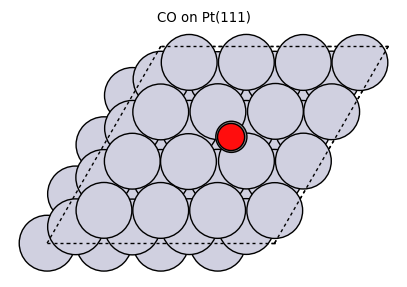


Adsorption Energy (E_ads) = -1.9603 eV


In [ ]:
from ase.build import molecule, surface, add_adsorbate
from ase.constraints import FixAtoms

def optimize_structure(atoms, output_name):
    atoms.calc = mace_mp(model="medium", dispersion=True, default_dtype="float64", device='cpu')
    opt = BFGS(atoms, trajectory=output_name + '.traj', logfile=output_name + '.log')
    opt.run(fmax=0.05)
    write(output_name + '.xyz', atoms)
    return atoms

def plot_structure(atoms, title):
    fig, ax = plt.subplots(figsize=(5, 5))
    plot_atoms(atoms, ax, rotation=('0x,0y,0z'))
    ax.set_title(title)
    ax.axis('off')
    plt.show()


adsorbate = molecule('CO')
adsorbate.center(vacuum=5.0)
ads = optimize_structure(adsorbate, 'adsorbate_optimized')

# 2. Create clean Pt(111) surface
slab = surface('Pt', (1, 1, 1), layers=3, vacuum=5.0)
slab = slab.repeat((2, 2, 1))  # 3x3 in-plane replication
slab.center(axis=2, vacuum=5.0)

# Fix bottom layer
constraint = FixAtoms(indices=[atom.index for atom in slab if atom.position[2] < slab.positions[:,2].mean()])
slab.set_constraint(constraint)
surf = optimize_structure(slab, 'surface_optimized')

# 3. Add CO adsorbate to surface
slab_ads = slab.copy()

# Manually pick an (x, y) position for adsorption, e.g., above the first Pt atom
z_positions = slab.positions[:, 2]
z_max = z_positions.max()
tolerance = 0.5  # Angstroms

# Get indices of atoms in the top layer
top_layer_indices = [i for i, z in enumerate(z_positions) if abs(z - z_max) < tolerance]

# Compute the average XY position of the top layer
xy_positions = slab.positions[top_layer_indices][:, :2]
center_xy = np.mean(xy_positions, axis=0)

# Place adsorbate at center bridge (or ontop) of slab
add_adsorbate(slab_ads, adsorbate, height=2.0, position=center_xy)
slab_ads.center(vacuum=10.0, axis=2)

ads_surf = optimize_structure(slab_ads, 'ads_surf_optimized')
view(ads_surf)
plot_structure(ads_surf, "CO on Pt(111)")

# 4. Compute adsorption energy
E_ads = ads_surf.get_potential_energy()
E_adsorbate = ads.get_potential_energy()
E_surface = surf.get_potential_energy()
E_adsorption = E_ads - (E_surface + E_adsorbate)

print(f"\nAdsorption Energy (E_ads) = {E_adsorption:.4f} eV")